<a href="https://colab.research.google.com/github/Y4-Deep-Learning-Assignment/Pneumonia-_Detection/blob/Densenet-121/Pneumonia_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# =========================
# DenseNet121 — Chest X-ray Pneumonia (PyTorch)
# Metrics: Accuracy, Precision, Recall, F1, Confusion Matrix, ROC-AUC
# Curves: Training vs Validation Loss/Accuracy
# =========================

In [1]:
# Core
import os, copy, time, math, random, warnings
warnings.filterwarnings('ignore')

In [2]:
# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models

In [3]:
# Data / Viz
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

In [4]:
# Metrics
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, roc_curve
)

In [5]:
# ============== Config ==============
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)


Device: cpu


In [6]:
# >>>>>>> CHANGE THIS TO YOUR DATA ROOT (contains train/ val/ test/) <<<<<<<
DATA_DIR = '/content/drive/MyDrive/chest_xray'  # or '/path/to/chest_xray'
TRAIN_DIR = os.path.join(DATA_DIR, 'train')
VAL_DIR   = os.path.join(DATA_DIR, 'val')
TEST_DIR  = os.path.join(DATA_DIR, 'test')

BATCH_SIZE = 32
NUM_WORKERS = 2
EPOCHS = 20
PATIENCE = 5
LR = 1e-4
CHECKPOINT_PATH = 'densenet121_pneumonia_best.pth'

In [7]:
# ============== Transforms & Data ==============
train_tfms = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.85, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.05, contrast=0.05),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225]),
])

testval_tfms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225]),
])

train_ds = datasets.ImageFolder(TRAIN_DIR, transform=train_tfms)
val_ds   = datasets.ImageFolder(VAL_DIR,   transform=testval_tfms)
test_ds  = datasets.ImageFolder(TEST_DIR,  transform=testval_tfms)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=True)

class_names = train_ds.classes
print("Classes:", class_names)


Classes: ['NORMAL', 'PNEUMONIA']


In [8]:
# ============== Class Imbalance (Weights) ==============
targets = np.array(train_ds.targets)  # list of 0/1 labels
class_counts = np.bincount(targets)
# pos_weight for BCEWithLogitsLoss is (#neg / #pos)
pos_weight = torch.tensor(class_counts[0] / max(1, class_counts[1]), dtype=torch.float32, device=DEVICE)
print("Train class counts:", class_counts, " -> pos_weight:", float(pos_weight))

Train class counts: [1341 3875]  -> pos_weight: 0.3460645079612732


In [9]:
# ============== DenseNet121 ==============
model = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)
in_feats = model.classifier.in_features
model.classifier = nn.Linear(in_feats, 1)  # single logit for binary
model = model.to(DEVICE)


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


100%|██████████| 30.8M/30.8M [00:00<00:00, 59.2MB/s]


In [10]:
# (Optional) Fine-tuning strategy: unfreeze last dense block + norm5
for p in model.parameters():
    p.requires_grad = False
for name, p in model.features.named_parameters():
    if "denseblock4" in name or "norm5" in name:
        p.requires_grad = True
# Always train classifier
for p in model.classifier.parameters():
    p.requires_grad = True

In [11]:
# ============== Loss, Optim, Scheduler ==============
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)  # handles imbalance
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=LR, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.3)
scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())

In [12]:
# ============== Train/Val Loop ==============
def run_epoch(loader, train_mode=True):
    model.train(mode=train_mode)
    total_loss = 0.0
    y_true, y_prob = [], []
    if train_mode:
        optimizer.zero_grad(set_to_none=True)

    for images, labels in loader:
        images = images.to(DEVICE, non_blocking=True)
        labels = labels.float().unsqueeze(1).to(DEVICE, non_blocking=True)

        with torch.set_grad_enabled(train_mode):
            with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
                logits = model(images)
                loss = criterion(logits, labels)

            if train_mode:
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad(set_to_none=True)

        total_loss += loss.item() * images.size(0)
        probs = torch.sigmoid(logits).detach().cpu().numpy().ravel()
        y_prob.extend(probs.tolist())
        y_true.extend(labels.detach().cpu().numpy().ravel().tolist())

    avg_loss = total_loss / len(loader.dataset)
    y_prob = np.array(y_prob)
    y_true = np.array(y_true)
    y_pred = (y_prob >= 0.5).astype(int)

    acc  = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec  = recall_score(y_true, y_pred, zero_division=0)
    f1   = f1_score(y_true, y_pred, zero_division=0)
    try:
        auc  = roc_auc_score(y_true, y_prob)
    except ValueError:
        auc = float('nan')

    return avg_loss, acc, prec, rec, f1, auc, y_true, y_prob, y_pred

def fit(epochs=EPOCHS, patience=PATIENCE, ckpt_path=CHECKPOINT_PATH):
    best_w = copy.deepcopy(model.state_dict())
    best_val = math.inf
    wait = 0

    history = {'train_loss':[], 'val_loss':[], 'train_acc':[], 'val_acc':[]}

    start = time.time()
    for ep in range(1, epochs+1):
        tl, ta, _, _, _, _, _, _, _ = run_epoch(train_loader, train_mode=True)
        vl, va, vp, vrc, vf1, vauc, _, _, _ = run_epoch(val_loader,   train_mode=False)
        scheduler.step(vl)

        history['train_loss'].append(tl); history['val_loss'].append(vl)
        history['train_acc'].append(ta);  history['val_acc'].append(va)

        print(f"[{ep:02d}/{epochs}] Train loss {tl:.4f} acc {ta:.3f} | "
              f"Val loss {vl:.4f} acc {va:.3f} (P {vp:.3f} R {vrc:.3f} F1 {vf1:.3f} AUC {vauc:.3f})")

        if vl < best_val:
            best_val = vl; wait = 0
            best_w = copy.deepcopy(model.state_dict())
            torch.save({'model':'densenet121','state_dict':best_w}, ckpt_path)
        else:
            wait += 1
            if wait >= patience:
                print(f"Early stopping at epoch {ep}. Best val loss: {best_val:.4f}")
                break

    total_time = time.time() - start
    print(f"Training complete in {total_time/60:.1f} min. Best val loss: {best_val:.4f}")
    model.load_state_dict(best_w)
    return history

history = fit()


[01/20] Train loss 0.1086 acc 0.909 | Val loss 0.4527 acc 0.750 (P 0.667 R 1.000 F1 0.800 AUC 1.000)
[02/20] Train loss 0.0590 acc 0.958 | Val loss 0.4489 acc 0.750 (P 0.667 R 1.000 F1 0.800 AUC 1.000)
[03/20] Train loss 0.0523 acc 0.962 | Val loss 0.8806 acc 0.625 (P 0.571 R 1.000 F1 0.727 AUC 0.984)
[04/20] Train loss 0.0410 acc 0.971 | Val loss 0.7283 acc 0.688 (P 0.615 R 1.000 F1 0.762 AUC 1.000)
[05/20] Train loss 0.0383 acc 0.974 | Val loss 0.8911 acc 0.688 (P 0.615 R 1.000 F1 0.762 AUC 0.984)
[06/20] Train loss 0.0362 acc 0.973 | Val loss 0.8872 acc 0.688 (P 0.615 R 1.000 F1 0.762 AUC 1.000)
[07/20] Train loss 0.0298 acc 0.980 | Val loss 0.8454 acc 0.688 (P 0.615 R 1.000 F1 0.762 AUC 1.000)
Early stopping at epoch 7. Best val loss: 0.4489
Training complete in 138.4 min. Best val loss: 0.4489


In [13]:
# ============== Train/Val Loop ==============
def run_epoch(loader, train_mode=True):
    model.train(mode=train_mode)
    total_loss = 0.0
    y_true, y_prob = [], []
    if train_mode:
        optimizer.zero_grad(set_to_none=True)

    for images, labels in loader:
        images = images.to(DEVICE, non_blocking=True)
        labels = labels.float().unsqueeze(1).to(DEVICE, non_blocking=True)

        with torch.set_grad_enabled(train_mode):
            with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
                logits = model(images)
                loss = criterion(logits, labels)

            if train_mode:
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad(set_to_none=True)

        total_loss += loss.item() * images.size(0)
        probs = torch.sigmoid(logits).detach().cpu().numpy().ravel()
        y_prob.extend(probs.tolist())
        y_true.extend(labels.detach().cpu().numpy().ravel().tolist())

    avg_loss = total_loss / len(loader.dataset)
    y_prob = np.array(y_prob)
    y_true = np.array(y_true)
    y_pred = (y_prob >= 0.5).astype(int)

    acc  = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec  = recall_score(y_true, y_pred, zero_division=0)
    f1   = f1_score(y_true, y_pred, zero_division=0)
    try:
        auc  = roc_auc_score(y_true, y_prob)
    except ValueError:
        auc = float('nan')

    return avg_loss, acc, prec, rec, f1, auc, y_true, y_prob, y_pred

def fit(epochs=EPOCHS, patience=PATIENCE, ckpt_path=CHECKPOINT_PATH):
    best_w = copy.deepcopy(model.state_dict())
    best_val = math.inf
    wait = 0

    history = {'train_loss':[], 'val_loss':[], 'train_acc':[], 'val_acc':[]}

    start = time.time()
    for ep in range(1, epochs+1):
        tl, ta, _, _, _, _, _, _, _ = run_epoch(train_loader, train_mode=True)
        vl, va, vp, vrc, vf1, vauc, _, _, _ = run_epoch(val_loader,   train_mode=False)
        scheduler.step(vl)

        history['train_loss'].append(tl); history['val_loss'].append(vl)
        history['train_acc'].append(ta);  history['val_acc'].append(va)

        print(f"[{ep:02d}/{epochs}] Train loss {tl:.4f} acc {ta:.3f} | "
              f"Val loss {vl:.4f} acc {va:.3f} (P {vp:.3f} R {vrc:.3f} F1 {vf1:.3f} AUC {vauc:.3f})")

        if vl < best_val:
            best_val = vl; wait = 0
            best_w = copy.deepcopy(model.state_dict())
            torch.save({'model':'densenet121','state_dict':best_w}, ckpt_path)
        else:
            wait += 1
            if wait >= patience:
                print(f"Early stopping at epoch {ep}. Best val loss: {best_val:.4f}")
                break

    total_time = time.time() - start
    print(f"Training complete in {total_time/60:.1f} min. Best val loss: {best_val:.4f}")
    model.load_state_dict(best_w)
    return history

history = fit()


[01/20] Train loss 0.0482 acc 0.965 | Val loss 0.6471 acc 0.625 (P 0.571 R 1.000 F1 0.727 AUC 0.984)
[02/20] Train loss 0.0424 acc 0.967 | Val loss 0.7322 acc 0.625 (P 0.571 R 1.000 F1 0.727 AUC 0.969)
[03/20] Train loss 0.0463 acc 0.966 | Val loss 0.7171 acc 0.625 (P 0.571 R 1.000 F1 0.727 AUC 0.984)
[04/20] Train loss 0.0449 acc 0.967 | Val loss 0.6854 acc 0.688 (P 0.615 R 1.000 F1 0.762 AUC 0.984)
[05/20] Train loss 0.0429 acc 0.972 | Val loss 0.6818 acc 0.688 (P 0.615 R 1.000 F1 0.762 AUC 0.984)
[06/20] Train loss 0.0428 acc 0.971 | Val loss 0.6752 acc 0.688 (P 0.615 R 1.000 F1 0.762 AUC 0.984)
Early stopping at epoch 6. Best val loss: 0.6471
Training complete in 108.8 min. Best val loss: 0.6471



=== Test Metrics (DenseNet121) ===
Loss: 0.5873
Accuracy:  0.8045
Precision: 0.7638
Recall:    0.9949
F1-Score:  0.8641
ROC-AUC:   0.9327

Confusion Matrix:
 [[114 120]
 [  2 388]]


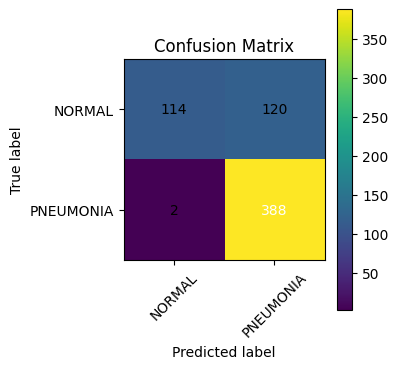

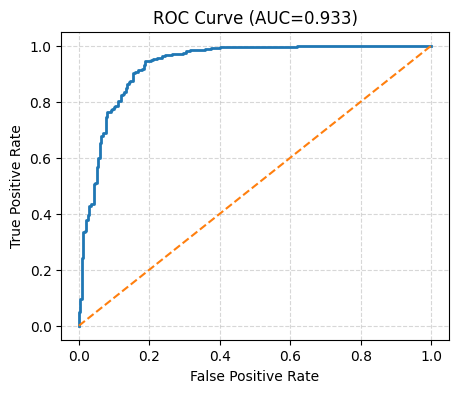


Summary: {'test_loss': 0.587315618332165, 'accuracy': 0.8044871794871795, 'precision': 0.7637795275590551, 'recall': 0.9948717948717949, 'f1': 0.8641425389755011, 'auc': np.float64(0.9327087442472057)}


In [14]:
# ============== Test Evaluation ==============
def evaluate_test():
    tl, acc, prec, rec, f1, auc, y_true, y_prob, y_pred = run_epoch(test_loader, train_mode=False)

    print("\n=== Test Metrics (DenseNet121) ===")
    print(f"Loss: {tl:.4f}")
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1-Score:  {f1:.4f}")
    print(f"ROC-AUC:   {auc:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    print("\nConfusion Matrix:\n", cm)

    # Plot Confusion Matrix
    plt.figure(figsize=(4,4))
    plt.imshow(cm, interpolation='nearest')
    plt.title('Confusion Matrix'); plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label'); plt.xlabel('Predicted label')
    plt.tight_layout(); plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr, lw=2)
    plt.plot([0,1],[0,1],'--')
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve (AUC={auc:.3f})')
    plt.grid(True, ls='--', alpha=0.5)
    plt.show()

    return {
        'test_loss': tl, 'accuracy': acc, 'precision': prec,
        'recall': rec, 'f1': f1, 'auc': auc
    }

# Load best weights (safety) and evaluate
ckpt = torch.load(CHECKPOINT_PATH, map_location=DEVICE)
model.load_state_dict(ckpt['state_dict'])
test_results = evaluate_test()
print("\nSummary:", test_results)